In [1]:
using Plots, LinearAlgebra

In [2]:
mutable struct auto
    posicion ::Array{Real, 1}
    velocidad ::Array{Real, 1}
    direccion ::Array{Real, 1}
    longitud ::Real
    ancho ::Real
    velocidad_maxima ::Real
    color ::Symbol
end

In [3]:
import Plots.plot!

rota(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]
function plot!(auto1::auto, lw = 1)
    θ = atan(auto1.direccion[2],auto1.direccion[1])-π/2
    R = rota(θ)
    vn = auto1.direccion./norm(auto1.direccion)
    x = auto1.posicion[1]#-vn[1]*auto1.longitud/2
    y = auto1.posicion[2]#-vn[2]*auto1.longitud/2
    x1 = auto1.posicion[1]-auto1.ancho/2
    x2 = auto1.posicion[1]-auto1.ancho/2
    x3 = auto1.posicion[1]+auto1.ancho/2
    x4 = auto1.posicion[1]+auto1.ancho/2
    y1 = auto1.posicion[2]-auto1.longitud/2
    y2 = auto1.posicion[2]+auto1.longitud/2
    y3 = auto1.posicion[2]+auto1.longitud/2
    y4 = auto1.posicion[2]-auto1.longitud/2

    x11 = auto1.posicion[1]-0.7*auto1.ancho/2
    x21 = auto1.posicion[1]-0.7*auto1.ancho/2
    x31 = auto1.posicion[1]+0.7*auto1.ancho/2
    x41 = auto1.posicion[1]+0.7*auto1.ancho/2
    y11 = auto1.posicion[2]-0.6*auto1.longitud/2
    y21 = auto1.posicion[2]+0.4*auto1.longitud/2
    y31 = auto1.posicion[2]+0.4*auto1.longitud/2
    y41 = auto1.posicion[2]-0.6*auto1.longitud/2
    
    M = [x1-x x2-x x3-x x4-x x11-x x21-x x31-x x41-x; y1-y y2-y y3-y y4-y y11-y y21-y y31-y y41-y]
    M = R*M
    x1, x2, x3, x4 = M[1,1]+x, M[1,2]+x, M[1,3]+x, M[1,4]+x
    x11, x21, x31, x41 = M[1,5]+x, M[1,6]+x, M[1,7]+x, M[1,8]+x
    y1, y2, y3, y4 = M[2,1]+y, M[2,2]+y, M[2,3]+y, M[2,4]+y
    y11, y21, y31, y41 = M[2,5]+y, M[2,6]+y, M[2,7]+y, M[2,8]+y
    plot!([x1,x2,x3,x4,x1], [y1,y2,y3,y4,y1], color = auto1.color, linewidth = lw, fill = true, alpha = 0.4)
    plot!([x11,x21,x31,x41,x11], [y11,y21,y31,y41,y11], color = auto1.color, linewidth = lw, fill = true, alpha = 1)
end

plot! (generic function with 5 methods)

In [4]:
function actualizar_posicion(auto1::auto, t; longitud_calle = 550)
    auto1.posicion = auto1.posicion .+ auto1.velocidad * t
    auto1.posicion[2] = mod(auto1.posicion[2], longitud_calle)  
    return auto1
end

function actualizar_posicion_cambio_carril(auto1::auto, carril, t, θ; longitud_calle = 550)
    R = rota(θ)
    auto1.velocidad = R*auto1.velocidad
    s = sign(auto1.velocidad[1])
    terminó = false
    if norm(vocho.velocidad) ≠ 0
        vocho.direccion = vocho.velocidad
    end
    t1 = (carril-s*1 - auto1.posicion[1])/(auto1.velocidad[1])
    t0 = t
    if t1 >= 0
        t0 = min(t, t1)
    else
        R = rota(-θ)
        auto1.velocidad = R*R*auto1.velocidad
        if norm(vocho.velocidad) ≠ 0
            vocho.direccion = vocho.velocidad
        end
    end
    if abs(auto1.velocidad[1])<0.001
        auto1.velocidad[1] = 0
        auto1.posicion[1] = round(auto1.posicion[1])
        terminó = true
    end

    t2 = t-t0
    auto1 = actualizar_posicion(auto1, t0, longitud_calle = longitud_calle)
    if t2 > 0
        R = rota(-θ)
        auto1.velocidad = R*auto1.velocidad
        if norm(vocho.velocidad) ≠ 0
            vocho.direccion = vocho.velocidad
        end
        auto1 = actualizar_posicion(auto1, t2, longitud_calle = longitud_calle)
    end
    return auto1, terminó
end

function actualizar_velocidades(autos::Vector{auto}, t; longitud_calle = 550)
    n = length(autos)
    for i in 1:n
        k = mod1(i+1, n)
        d = 0
        if autos[k].posicion[2]-autos[i].posicion[2]> 0
            d = autos[k].posicion[2]-autos[i].posicion[2]
        else
            d = autos[k].posicion[2]+longitud_calle-autos[i].posicion[2]
        end
        d_segura = autos[i].velocidad[2]*t + autos[i].longitud/2 + autos[k].longitud/2
        if d< autos[i].longitud/2 + autos[k].longitud/2
            return error("chocaron $i y $k, $d_segura")
        end
        dv = autos[k].velocidad[2]-autos[i].velocidad[2]
        δv = min(autos[i].velocidad_maxima-autos[i].velocidad[2], 0.1, (d-d_segura)/t-autos[i].velocidad[2])

        autos[i].velocidad[2] = max(autos[i].velocidad[2]+δv, 0)
    end
    return autos
end  

function encontrar_autos(autos, auto1)
    y_cofre = auto1.posicion[2]+auto1.longitud/2
    I = sortperm(autos, by = x-> x.posicion[2], rev = true)
    i = findfirst(x -> x.posicion[2]+auto1.longitud/2< y_cofre, autos[I])
    return I[i], I[i]+1
end

function maximo_giro(auto)
    v = norm(auto.velocidad)
    θ = π/2*(1/(0.5*v+1))^(1/4)
end

function punto_interseccion(auto, δt, θ, carril; longitud_calle = 550)
    l = auto.longitud
    w = auto.ancho
    signo = sign(carril-auto.posicion[1])
    r = abs(auto.velocidad[2]*δt/θ)
    r22 = (r-w/2)^2
    c = auto.posicion +signo*[r, 0]
    y = mod(c[2]+√(r22 - (carril -signo*1-c[1])^2), longitud_calle)
    return y
end

aceleracion(auto, d) = -norm(auto.velocidad)/(2*d)

aceleracion (generic function with 1 method)

$ \dot \omega  = \theta /t$ 

$ r = |v|t/\theta $

$r_2 = \sqrt(l^2 /4 +(r-w/2)^2)$

$c = auto1.posicion \pm [r, 0]$

$(carril\pm 1-c[1])^2 + (y-c[2])^2 = r_2 ^2$ 

$ y = c[2] + \sqrt{r_2 ^2-(carril\pm 1-c[1])^2}$


In [102]:

#### Falta esta función ####
function min_max(auto, separacion)
    
    
    
    return min1, max1, min2, max2
end

min_max (generic function with 1 method)

In [5]:
vocho = auto([1,1], [0.0, 5.1], [0.0, 1.1], 3.3, 1.5, 100, :red)
δt =0.1
θ = maximo_giro(vocho)*δt/5
carril = 3
punto_interseccion(vocho, δt, θ, carril)

4.271711436911577

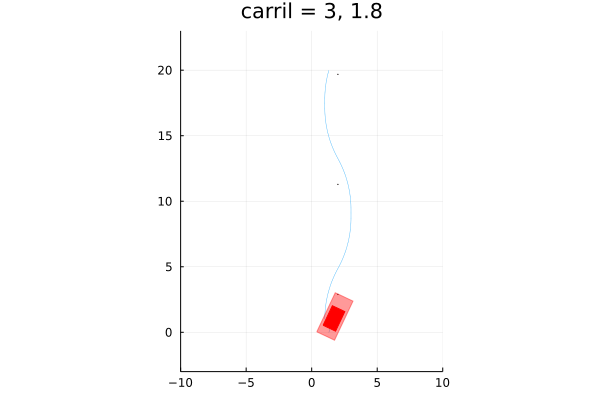

In [6]:
gr()
δt =0.01
vocho = auto([1,1], [0.0, 2.1], [0.0, 1.1], 3.3, 1.5, 100, :red)
θ = maximo_giro(vocho)*δt/5
T = 1000
X = zeros(T)
Y = zeros(T)
terminó = false
carril = 3
contador = 0
j = 0
X1 = [2]
Y1 = [punto_interseccion(vocho, δt, θ, carril, longitud_calle = 20)]
plot(show = :ijulia)
 sleep(1)
for i in 1:T
    if !terminó
        vocho, terminó = actualizar_posicion_cambio_carril(vocho, carril, δt, -θ, longitud_calle = 20)
    else
        
        contador += 1
        if contador == 1
            j += 1
            carril = carril + (-1)^j * 2
            θ *= -1
        end
        vocho = actualizar_posicion(vocho, δt, longitud_calle = 20)
        if contador >30
            push!(X1, 2)
            push!(Y1, punto_interseccion(vocho, δt, θ, carril, longitud_calle = 20))

            terminó = false
            contador = 0
        end
    end
    X[i] = vocho.posicion[1]
    Y[i] = vocho.posicion[2]
    plot(key = false, aspect_ratio = 1, xlim = (-10, 10), ylim = (-3, 23))
    scatter!(X[1:2:i],Y[1:2:i], markerstrokewidth = 0, markersize = .5)
    scatter!(X1, Y1, markersize = 0.5)
    plot!(vocho)
    plot!(show = :ijulia, title = "carril = $carril, $(round(10*vocho.posicion[1])/10)")

end

In [41]:
vocho

auto(Real[-6.709273536744798, 3.5427152134686386], Real[-0.14804934210807968, 1.0899914643249915], Real[-0.14804934210807968, 1.0899914643249915], 3.3, 1.5, 100, :red)